### Deepfakes - Travaux Jupyter Notebook pour ADS

Ce projet à pour but de montrer deux moyens de créer des deepfakes. Leur usage est le même :

- Les Autoencodeurs
- Les Réseaux Génératifs Adversariaux (GAN)

Tous deux ont pour but de produire la même chose : une imitation de quelque chose selon des images données.

Dans les deux exemples, les modèles seront entraînés avec CelebA, une liste de têtes de célébrités connues, disponibles [ici](https://www.kaggle.com/jessicali9530/celeba-dataset)

### Partie 1 - AutoEncodeurs - Import des librairies importantes pour la suite de ces écrits

In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 

Pour éviter tout les problèmes de mémoire et de surcharge kernel Jupyter, il nous faut créer notre propre manière d'ouvrir les fichiers.

In [2]:
WEIGHTS_FOLDER = 'weights'
DATA_FOLDER = 'img_align_celeba'
Z_DIM = 200

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [3]:
def build_decoder(test=False, out_size=(128, 128)):
    def decoder(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels=3)  
        img = tf.image.resize(img, out_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img
    def decoder_train(path):
        return decoder(path), decoder(path)

    return decoder if test else decoder_train

def build_dataset(paths, test=False, shuffle=1, batch_size=1):
    AUTO = tf.data.experimental.AUTOTUNE
    decoder = build_decoder(test)

    dset = tf.data.Dataset.from_tensor_slices(paths)
    dset = dset.map(decoder, num_parallel_calls=AUTO)
    
    dset = dset.shuffle(shuffle)
    dset = dset.batch(batch_size)
    return dset

In [4]:
train_paths, valid_paths, _, _ = train_test_split(filenames, filenames, test_size=0.2, shuffle=True)

train_dataset = build_dataset(train_paths, batch_size=128)
valid_dataset = build_dataset(valid_paths, batch_size=128)

### Partie 1.1 - Création du réseau neuronal

In [5]:
class VariableAutoencoder:
    def __init__(self):
        self.input_dim = (128,128,3)
        self.batch_size = 512
        self.z_dim = 200 # Dimension of the latent vector (z)
        self.learning_rate = 0.0005
        self.var_autoencoder_model = None
        self.var_encoder_model = None
        self.var_decoder_model = None

    def build(self):
        #Encoder
        input_encoder = Input(shape=(self.input_dim))
        x = Conv2D(32, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_1')(input_encoder)
        x = LeakyReLU()(x)
        x = Conv2D(64, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_2')(x)
        x = LeakyReLU()(x)
        x = Conv2D(64, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_3')(x)
        x = LeakyReLU()(x)
        x = Conv2D(64, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_4')(x)
        volumeSize = K.int_shape(x)
        x = Flatten()(x)

        latent_mu = Dense(self.z_dim, name='latent_mean')(x)
        latent_log_var = Dense(self.z_dim, name='latent_log_var')(x)
        
        def sampling(args=None):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]

            epsilon = K.random_normal(shape=(batch, self.z_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        latent_sample = Lambda(sampling)([latent_mu, latent_log_var])
        self.var_encoder_model = Model(input_encoder, latent_sample, name='encoder')

        latent_input = tf.keras.layers.Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(volumeSize[1:]))(latent_input)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        x = Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_1')(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_2')(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_3')(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(3, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_4')(x)
        output_decoder = Activation('sigmoid')(x)

        self.var_decoder_model = tf.keras.Model(latent_input, output_decoder, name='decoder')

        output_vae = self.var_decoder_model(self.var_encoder_model(input_encoder))
        self.var_autoencoder_model = tf.keras.Model(input_encoder, output_vae, name ='variable_autoencoder')

        reconstruction_loss = binary_crossentropy(input_encoder, output_vae) * (128 * 128)
        reconstruction_loss = K.mean(reconstruction_loss)

        kl_loss = 1 + latent_log_var - K.square(latent_mu) - K.exp(latent_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.var_autoencoder_model.add_loss(vae_loss)  
        self.var_autoencoder_model.add_metric(reconstruction_loss, name='reconstruction_loss')
        self.var_autoencoder_model.add_metric(kl_loss, name='kl_divergence_loss')

        optimizer = Adam(lr = self.learning_rate)

        self.var_autoencoder_model.compile(optimizer=optimizer)

        return None

    def get_varencoder(self):
        if self.var_encoder_model is not None:
            return self.var_encoder_model
        else:
            print("Variable Encoder model has not been defined!")
            return None

    def get_vardecoder(self):
        if self.var_decoder_model is not None:
            return self.var_decoder_model
        else:
            print("Variable Decoder model has not been defined!")
            return None
    
    def get_varautoencoder(self):
        if self.var_autoencoder_model is not None:
            return self.var_autoencoder_model
        else:
            print("Variable Autoencoder model has not been defined!")
            return None    

In [6]:
var_model = VariableAutoencoder()
var_model.build()

var_autoencoder = var_model.get_varautoencoder()
var_encoder = var_model.get_varencoder()
var_decoder = var_model.get_vardecoder()
var_autoencoder.summary()

Model: "variable_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           (None, 200)          1732048     ['input_1[0][0]']                
                                                                                                  
 decoder (Functional)           (None, 128, 128, 3)  916483      ['encoder[0][0]']                
                                                                                                  
 encoder_conv2d_1 (Conv2D)      (None, 64, 64, 32)   896         ['input_1[0][0

C:\Users\ielki\anaconda3\envs\workspace\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
VAE_N_EPOCHS = 10

checkpoint_vae_best = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/vae_best_model.h5'), 
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only = True, 
                                      verbose=1)
    
checkpoint_vae_last = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/vae_last_model.h5'),
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=False,
                                      save_weights_only=True)

var_autoencoder.fit(train_dataset,
                    epochs=VAE_N_EPOCHS,
                    callbacks=[checkpoint_vae_best, checkpoint_vae_last],
                    validation_data=valid_dataset)

Epoch 1/10
1267/1267 [==============================] - ETA: 0s - loss: 8661.9277 - reconstruction_loss: 8522.5527 - kl_divergence_loss: 139.3543
Epoch 1: val_loss improved from inf to 8368.62988, saving model to weights\VAE\vae_best_model.h5

Epoch 1: saving model to weights\VAE\vae_last_model.h5
1267/1267 [==============================] - 443s 346ms/step - loss: 8661.9277 - reconstruction_loss: 8522.5527 - kl_divergence_loss: 139.3543 - val_loss: 8368.6299 - val_reconstruction_loss: 8216.8682 - val_kl_divergence_loss: 151.7646
Epoch 2/10
1266/1267 [============================>.] - ETA: 0s - loss: 8333.4287 - reconstruction_loss: 8177.1558 - kl_divergence_loss: 156.2795
Epoch 2: val_loss improved from 8368.62988 to 8311.49316, saving model to weights\VAE\vae_best_model.h5

Epoch 2: saving model to weights\VAE\vae_last_model.h5
1267/1267 [==============================] - 279s 220ms/step - loss: 8333.5371 - reconstruction_loss: 8177.2549 - kl_divergence_loss: 156.2818 - val_loss: 831

In [33]:
test_dataset = build_dataset(valid_paths, test=True)
var_autoencoder.load_weights(os.path.join(WEIGHTS_FOLDER, 'VAE/vae_last_model.h5'))

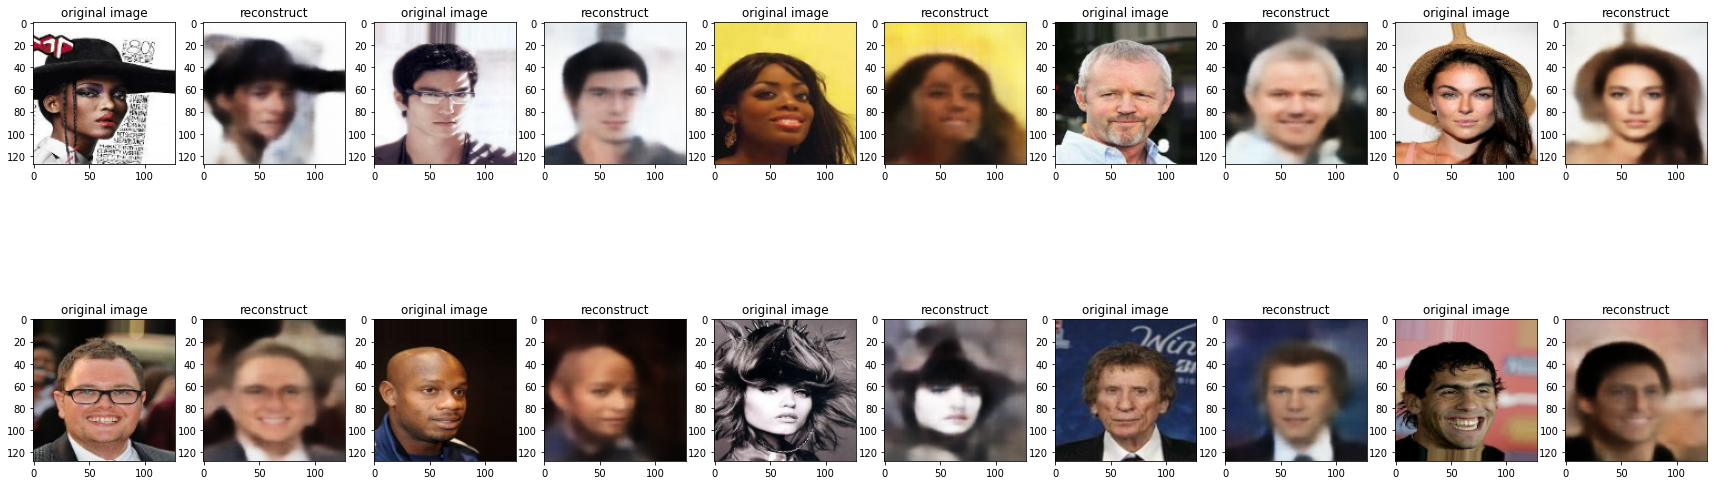

In [34]:
data = list(test_dataset.take(20))

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = var_autoencoder.predict(data[n])
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(np.squeeze(data[n]))
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.squeeze(image))
    plt.title('reconstruct')
    
plt.show()

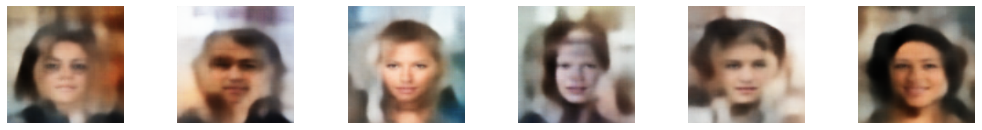

In [39]:
def vae_generate_images(new_to_show=10):
    random_codes = np.random.normal(size=(new_to_show, 200))
    new_faces = var_decoder.predict(np.array(random_codes))

    fig = plt.figure(figsize=(30, 15))

    for i in range(new_to_show):
        ax = fig.add_subplot(6, 10, i+1)
        ax.imshow(new_faces[i])
        ax.axis('off')
    plt.show()

vae_generate_images(6)

Comme vous pouvez le constater, il à créé des deepfakes avec succès, mais la qualité est plus ou moins au rendez-vous. Le problème majeur lié à ce type de réseau neuronal est lié au fait que les photos générées ont un flou plus ou moins important. C'est intrinsèque aux auto-encodeurs variationels, puisqu'il s'agit du bruit créé par l'encodeur et le décodeur lors de la manipulation de l'image.

En termes de performances, nous avons donc un modèle créé en 47,5 minutes, avec un résultat peu convaincant à première vue, mais il s'agit d'un bon début !